# HW 4: Network Modeling
---
## OR/ISE 501 - Fall 2021
__Assigned:__ Thu, 23 Sep (Groups of 2)  
__Due:__ 11:59p, Wed, 29 Sep

__Group Members:__ Kamlesh Pandey & Ronak Dhongde

Please use the Code cells in this Jupyter notebook to answer each of the following questions. You can add additional cells for each question if that helps in organizing your solution. Please run all of the cells in your notebook and then submit it via Moodle. (There is a _Run All Cells_ command under the _Run_ menu.)

In [1]:
using DataFrames

df = DataFrame(Item = ['A', 'B', 'C', 'D', 'E', 'F'], Value = [6, 5, 10, 8, 7, 3], 
                        Density = [12, 15, 8, 10, 32, 12])

df

,Item,Value,Density
,Char,Int64,Int64
1,A,6,12
2,B,5,15
3,C,10,8
4,D,8,10
5,E,7,32
6,F,3,12


In [3]:
using Optim, GLPK, JuMP

model = Model(GLPK.Optimizer)

p = df.Value   # price/value in $
d = df.Density # density in lb/ft^3

N = 1:length(p)  # for iteration in loop

@variable(model, 0 <= x[i = N])
@objective(model, Min, sum(p[i]*x[i] for i in N))
@constraint(model, sum(x[i] for i in N) <= 58e3)   # weight const
@constraint(model, sum(x[i]/d[i] for i in N) <= 2400)

println(model)
optimize!(model)

TC° = objective_value(model)
X° = value.(x)

Min 6 x[1] + 5 x[2] + 10 x[3] + 8 x[4] + 7 x[5] + 3 x[6]
Subject to
 x[1] + x[2] + x[3] + x[4] + x[5] + x[6] <= 58000.0
 0.08333333333333333 x[1] + 0.06666666666666667 x[2] + 0.125 x[3] + 0.1 x[4] + 0.03125 x[5] + 0.08333333333333333 x[6] <= 2400.0
 x[1] >= 0.0
 x[2] >= 0.0
 x[3] >= 0.0
 x[4] >= 0.0
 x[5] >= 0.0
 x[6] >= 0.0



1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

---
__(1)__ Four warehouses at the (_x_,_y_) coordinates listed for locations 1-4 in the table below supply, in total, 40, 55, 35, 70, and 25 tons of a single product each year to customers at locations 4-8, respectively. Unless otherwise noted, each of the following questions builds upon the previous questions:

| Location | _x_ | _y_ |
| :---: | :---: | :---: |
| 1 | -77.0300 | 38.8900 |
| 2 | -80.8256 | 39.4833 |
| 3 | -85.4043 | 31.6436 |
| 4 | -83.1209 | 33.6721 |
| 5 | -88.5150 | 35.0523 |
| 6 | -84.7100 | 34.5600 |
| 7 | -77.3951 | 37.0170 |
| 8 | -76.4400 | 37.3900 |

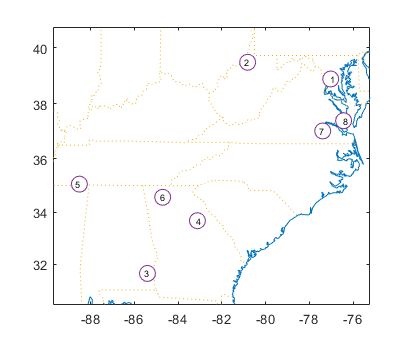

__(1*a*)__ Assuming that transport costs are proportional to Euclidean distance and that each warehouse can supply any amount of the product, determine the amount of product that should be supplied from each warehouse to each customer in order to minimize total cost.  

In [1]:
warehouse_loc = [-77.0300 38.89; -80.8256 39.4833; -85.4043 31.6436; -83.1209 33.6721]  # warehouse co-ordinates
customers_loc = [-83.1209 33.6721; -88.5150 35.0523; -84.7100 34.5600; -77.3951 37.0170; -76.4400 37.3900] # customer co-ordinates
demand = [40, 55, 35, 70, 25]   # given in the notebook
supply = [1/eps(), 1/eps(), 1/eps(), 1/eps()] # as warehouse can supply any amount


function distance_bw_points(x,P)  # function to calculate distance between the warehouse and customer locations
    
    sqrt.(sum((x' .-P).^2, dims = 2))
    
end

distance_matrix = vcat([distance_bw_points(customers_loc[i,:], warehouse_loc) for i in 1:size(customers_loc,1)]'...) #matrix return

cost_matrix = distance_matrix' # transpose to convert as per the supply and demand network

# As julia will not treat supplying product from Wh4 to Cust4 we have to pass a small value to the cost_matrix at (4,1)

cost_matrix[4,1] = sqrt(eps())

cost_matrix

4×5 adjoint(::Matrix{Float64}) with eltype Float64:
 8.02032     12.1092   8.81654  1.90825   1.61186
 6.24808      8.87472  6.27116  4.22504   4.85957
 3.0543       4.61473  2.99791  9.64472  10.648
 1.49012e-8   5.56788  1.82033  6.63122   7.64573

In [4]:
using JuMP, GLPK
function minimize_total_cost(C, demand, supply)
    D = 1:length(demand)
    S = 1:length(supply)
    model = Model(GLPK.Optimizer)
    @variable(model, 0<= X[1:length(S), 1:length(D)])
    @objective(model, Min, sum(C[i,j]*X[i,j] for i in S, j in D))
    for i in S
        @constraint(model, sum(X[i,j] for j in D) <= supply[i])
    end
    
    for j in D
        @constraint(model, sum(X[i,j] for i in S) == demand[j])
    end
    
    print(model)
    optimize!(model)
    return value.(X)
    
end

X° = minimize_total_cost(cost_matrix, demand, supply)

TC° = sum(cost_matrix.* X°)

X°

LoadError: UndefVarError: cost_matrix not defined

In [3]:
using DataFrames

df = DataFrame(Warehouse_Number = ['1', '1', '2', '3', '4', '4'], 
               Rcving_Customer = ['8', '7', '0', '2', '4', '6'], 
               Product_Supplied_in_Tons = [X°[1,5], X°[1,4], X°[2,2], X°[3,2], X°[4,1], X°[4,3]])
    



println("Total minimum cost for transportation model is:  ",  ceil(TC°))

println("\nThe quantity supplied from each warehouse to the customer is as follow...\n")

df

Total minimum cost for transportation model is:  492.0

The quantity supplied from each warehouse to the customer is as follow...



,Warehouse_Number,Rcving_Customer,Product_Supplied_in_Tons
,Char,Char,Float64
1,1,8,25.0
2,1,7,70.0
3,2,0,0.0
4,3,2,55.0
5,4,4,40.0
6,4,6,35.0


__(1*b*)__ In what unit of measure is the total cost given for this problem?

_Your Answer:_ degree tons

__(1*c*)__ What would be the change in the total cost if each warehouse was limited to supplying
up to 60 tons per year of the product, in total, to all of the customers?

In [4]:
warehouse_loc = [-77.0300 38.89; -80.8256 39.4833; -85.4043 31.6436; -83.1209 33.6721]  # warehouse co-ordinates
customers_loc = [-83.1209 33.6721; -88.5150 35.0523; -84.7100 34.5600; -77.3951 37.0170; -76.4400 37.3900] # customer co-ordinates
demand = [40, 55, 35, 70, 25]   # given in the notebook
supply = [60, 60, 60, 60]  # each warehouse can supply 60 tons

# total supply is greater than the total demand

using JuMP, GLPK

function change_in_cost_1c(C,Supply,Demand)
    S = 1:length(Supply)
    D = 1:length(Demand)
    
    model = Model(GLPK.Optimizer)
    @variable(model, 0 <= X[1:length(S), 1:length(D)])
    @objective(model, Min, sum(C[i,j]*X[i,j] for i in S, j in D))
    
    for i in S
        @constraint(model, sum(X[i,j] for j in D) <= Supply[i])
    end
    
    for j in D
        @constraint(model, sum(X[i,j] for i in S) == Demand[j])
    end
    #print(model)
    optimize!(model)
    return value.(X)
end

X° = change_in_cost_1c(cost_matrix,supply, demand)   
Tc° = sum(cost_matrix.*X°)

println("Total cost after 60 Ton restriction in Supply is: \$",ceil(Tc°))

delta_cost = 623 - 492
println("\n Total change in the cost : \$", delta_cost)

Total cost after 60 Ton restriction in Supply is: $623.0

 Total change in the cost : $131


__(1*d*)__ What would be the change in the total cost if the amount of the product that could be transported from each warehouse to each customer could not exceed 35 tons per year?

In [5]:
demand = [40, 55, 35, 70, 25]
supply = [60, 60, 60, 60]

using JuMP, GLPK

function change_in_cost_1d(C,Supply,Demand)
    
    S = 1:length(Supply)
    D = 1:length(Demand)
    
    model = Model(GLPK.Optimizer)
    
    
    @variable(model, 0 <= X[1:length(S), 1:length(D)] <= 35)
    
    
    @objective(model, Min, sum(C[i,j]*X[i,j] for i in S, j in D))
    
    for i in S
        @constraint(model, sum(X[i,j] for j in D) <= Supply[i])
    end
    
    for j in D
        @constraint(model, sum(X[i,j] for i in S) == Demand[j])
    end
    
    #println(model)
    optimize!(model)
    
    return value.(X)
    
end

Xϕ = change_in_cost_1d(cost_matrix,supply, demand)   
Tc° = sum(cost_matrix.*Xϕ)

println("Total cost after 35Ton restriction in demand: \$",ceil(Tc°))

delta_cost = 664-623

println("\n Total cost increased by: \$ ", delta_cost)


Total cost after 35Ton restriction in demand: $664.0

 Total cost increased by: $ 41


---
__(2)__ The cost of each arc is shown in the network below. Determine the least cost path from node 3 to node 6.

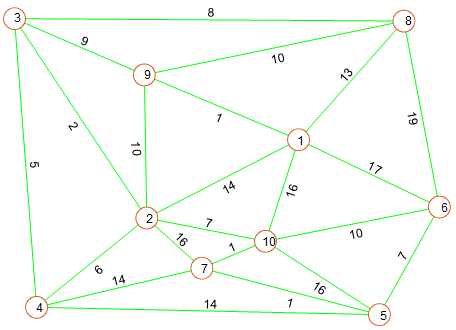

In [6]:
using LightGraphs, SimpleWeightedGraphs
i = [1,1,1,1,1,2,2,2,2,2,3,3,3,4,4,5,5,5,6,6,7,8]  # Index of starting node of each arc
j = [8,9,2,10,6,3,9,4,7,10,4,8,9,7,5,6,7,10,8,10,10,9]  # Index of ending node of each arc
w = [13,1,14,16,17,2,10,6,16,7,5,8,9,14,14,7,1,16,19,10,1,10]   # Weight (e.g., cost, distance, time) of each arc
G = SimpleWeightedGraph(i, j, w)    # Create undirected network

{10, 22} undirected simple Int64 graph with Int64 weights

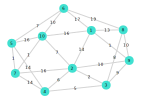

In [7]:
using Random, GraphPlot
Random.seed!(420000234567)
gplot(G, nodelabel=1:nv(G), edgelabel=[weights(G)[src(e),dst(e)] for e in edges(G)])

In [8]:
ds = dijkstra_shortest_paths(G,3) #shor from node 3 to all nodes
ds.dists     #dist from 3 to all nodes

10-element Vector{Int64}:
 10
  2
  0
  5
 11
 18
 10
  8
  9
  9

In [9]:
ds.parents   # nodes predecssors

10-element Vector{Int64}:
  9
  3
  0
  3
  7
  5
 10
  3
  3
  2

In [10]:
enumerate_paths(ds,6)   #path from node 3 to 6

6-element Vector{Int64}:
  3
  2
 10
  7
  5
  6

In [11]:
println("The shortest distance from node 3 to 6 is: ", ds.dists[6])

The shortest distance from node 3 to 6 is: 18


In [12]:
print("Shortes Path:   3-->2-->10-->7-->5-->6")

Shortes Path:   3-->2-->10-->7-->5-->6

---
__(3)__ Activity 5 takes six weeks and can start anytime after activity 2 is complete. Activity 8 takes four weeks and can start anytime after activities 2 and 9 are complete, and activity 2 takes eight weeks and can start after activities 7 and 10. Activity 9 takes seven weeks and can start after activity 1, activity 7 takes ten weeks and can start after activities 1 and 4, and activity 10 takes eight weeks and can start after activity 4. Activity 4 takes four weeks and can start after activity 3, and activity 1 takes six weeks and can start after activity 6 is complete. Activities 3 and 6 take five and eight weeks, respectively, and can start at any time. Determine the minimum number of weks required to complete all of the activities.

In [13]:
using DataFrames
activity = [1:10;]
pred = [6, [7, 10], 0, 3, 2, 0, [1, 4], [2,9], 1, 4]
time = [6, 8, 5, 4, 6, 8, 10, 4, 7, 10]


df = DataFrame(Activity = activity, Pred = pred, Time = time)
show(df, show_row_number = false)

10×3 DataFrame
 Activity  Pred     Time  
 Int64     Any      Int64 
──────────────────────────
        1  6            6
        2  [7, 10]      8
        3  0            5
        4  3            4
        5  2            6
        6  0            8
        7  [1, 4]      10
        8  [2, 9]       4
        9  1            7
       10  4           10

In [14]:
# determine intial activities i.e with no predecessors

initact = activity[pred .==0]

2-element Vector{Int64}:
 3
 6

In [15]:
if length(initact) > 1             # Add dummy start activity if multiple initial activities
    push!(activity, maximum(activity) + 1)
    push!(pred, 0)
    push!(time, 0)
    #push!(name, "(Start)")
    pred[initact] .= maximum(activity)  # Make dummy predecessor of original initial activities
    initact = maximum(activity)         # Make dummy the new initital activity
end
i = vcat(pred[pred .!= 0]...)      # Flatten pred nested array to single-level array
j = vcat([repeat([x],length(pred[x])) for x in activity[pred .!= 0]]...)   # Duplicate to match
t = time[i]
[i'; j'; t']

3×13 Matrix{Int64}:
 6   7  10  11  3  2  11  1  4  2  9  1   4
 1   2   2   3  4  5   6  7  7  8  8  9  10
 8  10  10   0  5  8   0  6  4  8  7  6   4

In [16]:
finalact = setdiff(j,i) 

push!(i, finalact...)              # Always need to add dummy final activity so that an
push!(activity, maximum(activity) + 1)       # arc can extend from original final activities that
push!(time, 0)                     # includes their times
#push!(name, "(Finish)")
push!(pred, finalact)
push!(j, repeat([activity[end]], length(finalact))...)
push!(t, time[finalact]...)
finalact = maximum(activity)
[i'; j'; t']

3×15 Matrix{Int64}:
 6   7  10  11  3  2  11  1  4  2  9  1   4   5   8
 1   2   2   3  4  5   6  7  7  8  8  9  10  12  12
 8  10  10   0  5  8   0  6  4  8  7  6   4   6   4

In [17]:
df = DataFrame(Activity = activity, Pred = pred, Time = time)
show(df, show_row_number=false)

12×3 DataFrame
 Activity  Pred     Time  
 Int64     Any      Int64 
──────────────────────────
        1  6            6
        2  [7, 10]      8
        3  11           5
        4  3            4
        5  2            6
        6  11           8
        7  [1, 4]      10
        8  [2, 9]       4
        9  1            7
       10  4           10
       11  0            0
       12  [5, 8]       0

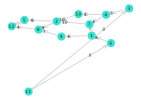

In [18]:
G = SimpleWeightedDiGraph(i, j, t)
Random.seed!(500)
gplot(G, nodelabel=activity, edgelabel=[weights(G)[src(e),dst(e)] for e in edges(G)])

In [19]:
G = SimpleWeightedDiGraph(i, j, -t)            # New graph with negative arc weights
ds = dijkstra_shortest_paths(G, initact)
criticalpath = enumerate_paths(ds, finalact)

7-element Vector{Int64}:
 11
  6
  1
  7
  2
  5
 12

In [20]:
mintime = -ds.dists[finalact]

println("Min time to finish the task: ",mintime )

Min time to finish the task: 38


---
__(4)__ A plant can use a three-stage process to produce a single product. A 13-week rolling horizon is used for planning production. The product's forecasted demand 13, 10, 10, 11, 23, 4, 14, 6, 13, 13, 6, 11, and 6 tons. The plant has production costs of \\$600, \\$110, and \$60 per ton for each stage, respectively, can produce up to 25 tons per week at each stage subject to availability. Stage 1 will not be available weeks 3, 5, 8, 9, and 11; stage 2, weeks 4, 8, and 10; stage 3 will not be available weeks 2, 6, 8, 12. When not available to produce this product, the capacity will be used for other products or scheduled maintenance. The inventory costs are \\$3.50, \\$4.00, and \\$4.40 per ton-month, for stages 1-3, respectively, and the initial and final inventory for all stages is five tons. Determine the amount of each product that should be produced to minimize total costs over the planning horizon.

In [21]:
d = [13, 10, 10, 11, 23, 4, 14, 6, 13, 13, 6, 11, 6]  # demand for 13 months period
U = [25 25 0 25 0 25 25 0 0 25 0 25 25;         #capacity at each stage (ton)
     25 25 25 0 25 25 25 0 25 0 25 25 25;
     25 0 25 25 25 0 25 0 25 25 25 0 25]

cp = [600, 110, 60]      # production cost at each stage $
ci = [3.50, 4.00, 4.40]  # inventory cost at each stage $/ton per week
y0 = [5, 5, 5]           # initial inventory at each stage (ton)
yt = [5, 5, 5]           # final inventory at each stage (ton)

m = length(cp)                   #length of production stage
t = length(d)                    # lenght of period of production
Ylb = [y0 zeros(m,t-1) yt]       # same LB and UB to fix inital and final inventory levels
Yub = [y0 repeat([1/sqrt(eps())],m,t-1) yt] #  max inventory storage level-> as max inv. is not specified, taken as 1/eps()

3×14 Matrix{Float64}:
 5.0  6.71089e7  6.71089e7  6.71089e7  …  6.71089e7  6.71089e7  5.0
 5.0  6.71089e7  6.71089e7  6.71089e7     6.71089e7  6.71089e7  5.0
 5.0  6.71089e7  6.71089e7  6.71089e7     6.71089e7  6.71089e7  5.0

In [22]:
using JuMP, GLPK
model = Model(GLPK.Optimizer)
@variable(model, 0 <= X[i=1:m, j=1:t] <= U[i,j] )
@variable(model, Ylb[i,j] <= Y[i=1:m, j=1:t+1] <= Yub[i,j] )
@objective(model, Min, sum(cp[i]*X[i,j] for i=1:m, j=1:t ) + 
    sum(ci[i]*Y[i,j] for i=1:m, j=2:t+1 ) )
for j = 1:t
    for i = 1:m-1
        @constraint(model, -X[i,j] + X[i+1,j] - Y[i,j] + Y[i,j+1] == 0 )   # (a)
    end
    @constraint(model, -X[m,j] - Y[m,j] + Y[m,j+1] == -d[j] )              # (b)
end
#print(model)
set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ALL)
optimize!(model)
TCᵒ = objective_value(model)
Xᵒ = value.(X)
Yᵒ = value.(Y)
TCᵒ, Xᵒ, Yᵒ

GLPK Simplex Optimizer 5.0
39 rows, 81 columns, 143 non-zeros
      0: obj =  5.950000000e+001 inf =  1.600e+002 (17)
     44: obj =  1.086147000e+005 inf =  0.000e+000 (0)
*    47: obj =  1.085927000e+005 inf =  0.000e+000 (0)
OPTIMAL LP SOLUTION FOUND


(108592.7, [8.0 23.0 … 0.0 21.0; 13.0 0.0 … 0.0 16.0; 18.0 0.0 … 0.0 11.0], [5.0 0.0 … 0.0 5.0; 5.0 0.0 … 0.0 5.0; 5.0 10.0 … 0.0 5.0])

In [23]:
println("The amount of product should be produced in each stage in the rolling period to minimise the cost: \n")

for rows = 1:3
    for cols = 1:13
        println(X[rows, cols], "---->",  Xᵒ[rows, cols], " ton")
    end
end

The amount of product should be produced in each stage in the rolling period to minimise the cost: 

X[1,1]---->8.0 ton
X[1,2]---->23.0 ton
X[1,3]---->0.0 ton
X[1,4]---->25.0 ton
X[1,5]---->0.0 ton
X[1,6]---->21.0 ton
X[1,7]---->25.0 ton
X[1,8]---->0.0 ton
X[1,9]---->0.0 ton
X[1,10]---->17.0 ton
X[1,11]---->0.0 ton
X[1,12]---->0.0 ton
X[1,13]---->21.0 ton
X[2,1]---->13.0 ton
X[2,2]---->0.0 ton
X[2,3]---->23.0 ton
X[2,4]---->0.0 ton
X[2,5]---->25.0 ton
X[2,6]---->0.0 ton
X[2,7]---->21.0 ton
X[2,8]---->0.0 ton
X[2,9]---->25.0 ton
X[2,10]---->0.0 ton
X[2,11]---->17.0 ton
X[2,12]---->0.0 ton
X[2,13]---->16.0 ton
X[3,1]---->18.0 ton
X[3,2]---->0.0 ton
X[3,3]---->10.0 ton
X[3,4]---->13.0 ton
X[3,5]---->25.0 ton
X[3,6]---->0.0 ton
X[3,7]---->20.0 ton
X[3,8]---->0.0 ton
X[3,9]---->13.0 ton
X[3,10]---->13.0 ton
X[3,11]---->17.0 ton
X[3,12]---->0.0 ton
X[3,13]---->11.0 ton
